H.	Exercises

Note: Answers for sections H are to be submitted in Week04_BetterTraining_Exercise.ipynb

1.	Write a new function resume_simple_network that loads a checkpoint_file from disk, restores both the optimizer and model states, and continues training to a specified total number of epochs. So if the model is saved after 20 epochs, and you specify 30 epochs, it should perform only 10 more epochs of training.

2.	We saw results on the make_moons dataset with a batch size of B = {1, 32, N}. Write a loop to train a new model on that same dataset for every power-of-two 	batch size less than N (i.e., B = {2, 4, 8, 16, 32; 64, ..}, and plot the results. Do you notice any trends in terms of accuracy and/or training time?

Try this:

3.	When performing experiments, we may want to go back and try versions of our model from different epochs, especially if we are trying to determine when some weird behaviour started to occur. Modify the train_simple_network function to take a new argument checkpoint_every_x that saves a version of the model every x epochs with different filenames. That way, you can go back and load a specific version without filling your hard drive with a model for every epoch.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
X_train, y_train = make_moons(n_samples=8000, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))

In [3]:
def resume_simple_network(model, optimizer, loss_func, train_loader, test_loader,
                          checkpoint_file, total_epochs, score_funcs=None):
    import torch
    from collections import defaultdict

    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

    device = next(model.parameters()).device
    history = defaultdict(list)

    for epoch in range(start_epoch, total_epochs + 1):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = loss_func(logits, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                logits = model(X_batch)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                y_true.extend(y_batch.numpy())
                y_pred.extend(preds)

        # Metrics
        if score_funcs:
            for name, func in score_funcs.items():
                score = func(y_true, y_pred)
                history[name].append(score)
        history['loss'].append(epoch_loss)

        print(f"Epoch {epoch}/{total_epochs} - Loss: {epoch_loss:.4f}")

    torch.save({
        'epoch': total_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_file)

    return history

Batch size 2: Accuracy = 0.8250, Time = 31.10s
Batch size 4: Accuracy = 0.8350, Time = 14.16s
Batch size 8: Accuracy = 0.8450, Time = 7.16s
Batch size 16: Accuracy = 0.8450, Time = 4.01s
Batch size 32: Accuracy = 0.8500, Time = 1.99s
Batch size 64: Accuracy = 0.8200, Time = 1.12s
Batch size 128: Accuracy = 0.8500, Time = 0.67s
Batch size 256: Accuracy = 0.8400, Time = 0.46s
Batch size 512: Accuracy = 0.8450, Time = 0.35s
Batch size 1024: Accuracy = 0.7950, Time = 0.28s
Batch size 2048: Accuracy = 0.8200, Time = 0.40s
Batch size 4096: Accuracy = 0.8300, Time = 0.40s


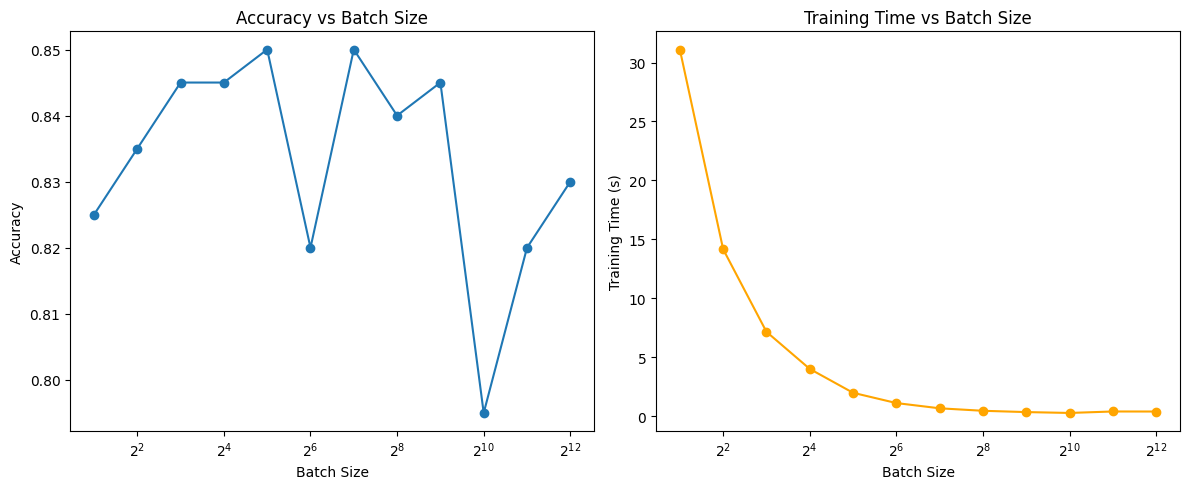

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import time

# X_train, y_train = make_moons(n_samples=8000, noise=0.4)
# X_test, y_test = make_moons(n_samples=200, noise=0.4)

# train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
#                               torch.tensor(y_train, dtype=torch.long))
# test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
#                              torch.tensor(y_test, dtype=torch.long))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model architecture
def create_model():
    return nn.Sequential(
        nn.Linear(2, 30),
        nn.Tanh(),
        nn.Linear(30, 30),
        nn.Tanh(),
        nn.Linear(30, 2)
    ).to(device)

# Training loop
def train_model(model, train_loader, loss_func, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = loss_func(logits, y_batch)
            loss.backward()
            optimizer.step()

# Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds)
    return accuracy_score(y_true, y_pred)

# Run experiments
batch_sizes = [2**i for i in range(1, int(np.log2(len(train_dataset))) + 1)]
results = []

for B in batch_sizes:
    train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    model = create_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_func = nn.CrossEntropyLoss()

    start_time = time.time()
    train_model(model, train_loader, loss_func, optimizer, epochs=5)
    duration = time.time() - start_time

    acc = evaluate_model(model, test_loader)
    results.append((B, acc, duration))
    print(f"Batch size {B}: Accuracy = {acc:.4f}, Time = {duration:.2f}s")

batch_sizes, accuracies, times = zip(*results)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(batch_sizes, accuracies, marker='o')
plt.xscale('log', base=2)
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Batch Size")

plt.subplot(1, 2, 2)
plt.plot(batch_sizes, times, marker='o', color='orange')
plt.xscale('log', base=2)
plt.xlabel("Batch Size")
plt.ylabel("Training Time (s)")
plt.title("Training Time vs Batch Size")

plt.tight_layout()
plt.show()

In [5]:
def train_simple_network(model, optimizer, loss_func, train_loader, test_loader,
                         epochs, checkpoint_file, device, checkpoint_every_x=None,
                         score_funcs=None):
    from collections import defaultdict

    history = defaultdict(list)

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = loss_func(logits, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                logits = model(X_batch)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                y_true.extend(y_batch.numpy())
                y_pred.extend(preds)

        # Metrics
        if score_funcs:
            for name, func in score_funcs.items():
                score = func(y_true, y_pred)
                history[name].append(score)
        history['loss'].append(epoch_loss)

        print(f"Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f}")

        # Save checkpoint every x epochs
        if checkpoint_every_x and epoch % checkpoint_every_x == 0:
            filename = f"{checkpoint_file.split('.pt')[0]}_epoch_{epoch}.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, filename)

    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_file)

    return history

In [8]:
# 3.	When performing experiments, we may want to go back and try versions of our
# model from different epochs, especially if we are trying to determine when some
# weird behaviour started to occur. Modify the train_simple_network function to
# take a new argument checkpoint_every_x that saves a version of the model every
# x epochs with different filenames. That way, you can go back and load a specific
#  version without filling your hard drive with a model for every epoch.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

def create_model():
    return nn.Sequential(
        nn.Linear(2, 30),
        nn.Tanh(),
        nn.Linear(30, 30),
        nn.Tanh(),
        nn.Linear(30, 2)
    ).to(device)

model = create_model()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# use the train_simple_network function with all required arguments
train_simple_network(
    model=model,
    optimizer=optimizer,
    loss_func=nn.CrossEntropyLoss(),
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=30,
    checkpoint_file='model.pt',
    device=device,
    checkpoint_every_x=10,
    score_funcs={'Acc': accuracy_score, 'F1': f1_score}
)

Epoch 1/30 - Loss: 48.9857
Epoch 2/30 - Loss: 43.0038
Epoch 3/30 - Loss: 40.1725
Epoch 4/30 - Loss: 40.7277
Epoch 5/30 - Loss: 39.9087
Epoch 6/30 - Loss: 40.0726
Epoch 7/30 - Loss: 39.7879
Epoch 8/30 - Loss: 39.8025
Epoch 9/30 - Loss: 39.6416
Epoch 10/30 - Loss: 39.8705
Epoch 11/30 - Loss: 39.4069
Epoch 12/30 - Loss: 39.6020
Epoch 13/30 - Loss: 39.8803
Epoch 14/30 - Loss: 39.5627
Epoch 15/30 - Loss: 39.6984
Epoch 16/30 - Loss: 39.7629
Epoch 17/30 - Loss: 39.6084
Epoch 18/30 - Loss: 39.5613
Epoch 19/30 - Loss: 40.0371
Epoch 20/30 - Loss: 39.8333
Epoch 21/30 - Loss: 39.8324
Epoch 22/30 - Loss: 39.6270
Epoch 23/30 - Loss: 39.3520
Epoch 24/30 - Loss: 39.3997
Epoch 25/30 - Loss: 39.6224
Epoch 26/30 - Loss: 39.7996
Epoch 27/30 - Loss: 39.4538
Epoch 28/30 - Loss: 39.5563
Epoch 29/30 - Loss: 39.5053
Epoch 30/30 - Loss: 39.5860


defaultdict(list,
            {'Acc': [0.825,
              0.84,
              0.83,
              0.845,
              0.84,
              0.85,
              0.855,
              0.85,
              0.845,
              0.85,
              0.835,
              0.85,
              0.845,
              0.845,
              0.825,
              0.83,
              0.85,
              0.845,
              0.845,
              0.85,
              0.85,
              0.85,
              0.84,
              0.845,
              0.84,
              0.85,
              0.83,
              0.84,
              0.845,
              0.835],
             'F1': [0.8241206030150754,
              0.8367346938775511,
              0.8316831683168316,
              0.8359788359788359,
              0.8367346938775511,
              0.8404255319148937,
              0.8481675392670157,
              0.845360824742268,
              0.8393782383419689,
              0.845360824742268,
              0.8